# DeepDigits: Handwritten Digit Recognition with Convolutional Neural Networks


Welcome to our Digit Recognizer Project! 

This Jupyter Notebook contains the code and steps for building a convolutional neural network (CNN) to recognize handwritten digits. The goal of this project is to demonstrate the process of creating, training, and evaluating a CNN using the popular MNIST dataset.

- Table of Contents
- Import Necessary Libraries
- Load Data
- Prepare Data for Training
- Split Data into Training and Validation Sets
- Define the Neural Network Architecture
- Compile the Model
- Data Augmentation
- Learning Rate Annealing with ReduceLROnPlateau
- Train the Model
- Visualize Training and Validation Metrics
- Make Predictions and Create Submission
- Conclusion

### Import Necessary Libraries

In this section, essential libraries are imported to facilitate data manipulation, visualization, and building the neural network. Libraries like NumPy, pandas, scikit-learn, and TensorFlow/Keras are included.


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras import layers
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau



### Load Data

The training and test datasets are loaded using pandas' read_csv function. These datasets contain images of handwritten digits and labels indicating the digit represented in each image.

In [17]:
test = pd.read_csv('/Users/gabriel/Library/CloudStorage/OneDrive-Pessoal/Data_Science/Projetos/Digit Recognizer/digit-recognizer/test.csv')
train = pd.read_csv('/Users/gabriel/Library/CloudStorage/OneDrive-Pessoal/Data_Science/Projetos/Digit Recognizer/digit-recognizer/train.csv')

# Check the shape of the training and test datasets
print("Train dataset shape:", train.shape)
print("Test dataset shape:", test.shape)

Train dataset shape: (42000, 785)
Test dataset shape: (28000, 784)


  This indicates that the training dataset, for instance, comprises 42,000 samples, each with 785 features. Each sample likely consists of a label representing a digit (0-9) and 784 pixel values representing a 28x28 grayscale image.


### Prepare Data for Training

In this section, the training data is preprocessed. Images are converted into a suitable format, pixel values are normalized, and labels are one-hot encoded.

The reshape function transforms the 2D pixel array into a 4D format. The -1 sets the sample count based on input size. Dimensions 28x28 are image size, and 1 is the grayscale channel. This prepares data for convolutional neural networks, ensuring effective image processing during training.






In [18]:
# Prepare the data
X = train.drop("label", axis=1).values.reshape(-1, 28, 28, 1) #!
y = to_categorical(train["label"], num_classes=10)


### Split Data into Training and Validation Sets

The data is split into training and validation sets using the train_test_split function from scikit-learn. This helps in assessing the model's performance during training.

In [19]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


### Define the Neural Network Architecture

The neural network architecture is established using Keras' Sequential model. This model allows for building a sequence of layers, forming the foundation of the CNN. The architecture comprises various layers that contribute to the network's ability to extract features and learn patterns from the input data.

Convolutional Layers: These layers apply filters to the input images to detect various features like edges, corners, or textures. The Conv2D layers are stacked to perform successive feature extraction.

Max-Pooling Layers: These layers downsample the feature maps, reducing their spatial dimensions while retaining essential information. They help in reducing computation while maintaining important features.

Dropout Layers: These layers help prevent overfitting by randomly deactivating a fraction of neurons during training. This promotes generalization and reduces dependency on specific neurons.

Fully Connected (Dense) Layers: After feature extraction, the data is flattened and fed into dense layers. These layers learn the relationships between different features and make the final predictions.

Output Layer (Dense with Softmax Activation): The last dense layer with the softmax activation function produces the final outputs. It converts the network's predictions into class probabilities. Each neuron in this layer represents a digit class (0-9), and the softmax activation ensures that the sum of the probabilities is 1.

The arrangement and configuration of these layers together define the architecture of the CNN. This structure is designed to effectively capture complex patterns and features present in the input images, enabling the network to make accurate predictions on the task at hand.

In [20]:
model = keras.Sequential([
    layers.Conv2D(64, (5, 5), activation='relu', input_shape=(28, 28, 1)),
    layers.BatchNormalization(),  # Batch normalization added
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(128, (5, 5), activation='relu'),
    layers.BatchNormalization(),  # Batch normalization added
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.BatchNormalization(),  # Batch normalization added
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),

    layers.Dense(10, activation='softmax')
])


### Compile the Model

The model is compiled with an optimizer (Adam), a loss function (categorical cross-entropy), and evaluation metrics (accuracy).

In [21]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


### Data Augmentation

The ImageDataGenerator serves a pivotal role in augmenting the training data in our code. By creating an instance of this generator and specifying various augmentation parameters, we enhance the diversity and richness of our training dataset. This augmentation, in turn, contributes to the robustness and generalization ability of the convolutional neural network (CNN) model.

The augmentation techniques, including rotation, width and height shifts, shearing, and zooming, introduce controlled variations to the training images. This process helps prevent overfitting, a phenomenon where the model becomes too tailored to the training data and struggles to perform well on new, unseen data.

By setting horizontal_flip and vertical_flip to False, we ensure that certain transformations that could confuse the model, such as horizontal and vertical flips that might change the interpretation of digits like 6 and 9, are avoided.

In [22]:
# Create an instance of the ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=10,          # Random rotation up to 10 degrees
    width_shift_range=0.1,      # Randomly shift width by up to 10% of image width
    height_shift_range=0.1,     # Randomly shift height by up to 10% of image height
    shear_range=0.2,            # Shear transformations
    zoom_range=0.1,             # Random zoom
    horizontal_flip=False,      # Horizontal flips
    vertical_flip=False,        # Vertical flips
    fill_mode='nearest'         # Fill mode for transformed pixels
)

### Learning Rate Annealing with ReduceLROnPlateau

A learning rate annealing technique is defined using ReduceLROnPlateau callback. The learning rate is adjusted based on validation loss and patience parameters.

The learning rate is a pivotal hyperparameter that governs the size of steps taken by the optimization algorithm in the parameter space. An ideal learning rate choice can expedite the model's convergence and efficacy, while a suboptimal value might lead to challenges such as slow convergence or divergence.

The ReduceLROnPlateau callback orchestrates the learning rate's course during training. It continually monitors validation loss. When this loss plateaus or doesn't improve substantially for a certain number of epochs (defined by patience), the callback reduces the learning rate (factor). This fine-tunes the model's parameter adjustments, fostering convergence. The min_lr guards against excessive reduction. In our case, with patience set to 3, a lack of significant improvement for three consecutive epochs triggers learning rate reduction, optimizing convergence effectively.



In [23]:
# Define the learning rate annealer
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', 
                                 factor=0.5,
                                 verbose = 1, 
                                 patience=3, 
                                 min_lr=0.00001)

### Train the Model

The model is trained using the training and validation data. Data augmentation, batch size, and the learning rate annealing callback are incorporated.

In [24]:
# Train the model and store the history with data augmentation and batch size selection
epochs = 30
batch_size = 128 
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=[lr_scheduler]
)

Epoch 1/30
263/263 [==============================] - 65s 241ms/step - loss: 0.4267 - accuracy: 0.8659 - val_loss: 0.0810 - val_accuracy: 0.9746 - lr: 0.0010
Epoch 2/30
263/263 [==============================] - 61s 233ms/step - loss: 0.1361 - accuracy: 0.9592 - val_loss: 0.0610 - val_accuracy: 0.9802 - lr: 0.0010
Epoch 3/30
263/263 [==============================] - 61s 231ms/step - loss: 0.0980 - accuracy: 0.9703 - val_loss: 0.0486 - val_accuracy: 0.9833 - lr: 0.0010
Epoch 4/30
263/263 [==============================] - 60s 228ms/step - loss: 0.0821 - accuracy: 0.9751 - val_loss: 0.0307 - val_accuracy: 0.9898 - lr: 0.0010
Epoch 5/30
263/263 [==============================] - 59s 225ms/step - loss: 0.0737 - accuracy: 0.9783 - val_loss: 0.0362 - val_accuracy: 0.9885 - lr: 0.0010
Epoch 6/30
263/263 [==============================] - 60s 227ms/step - loss: 0.0667 - accuracy: 0.9801 - val_loss: 0.0235 - val_accuracy: 0.9914 - lr: 0.0010
Epoch 7/30
263/263 [==============================] 

### Visualize Training and Validation Metrics

Training and validation accuracy and loss are visualized using matplotlib to assess model performance.

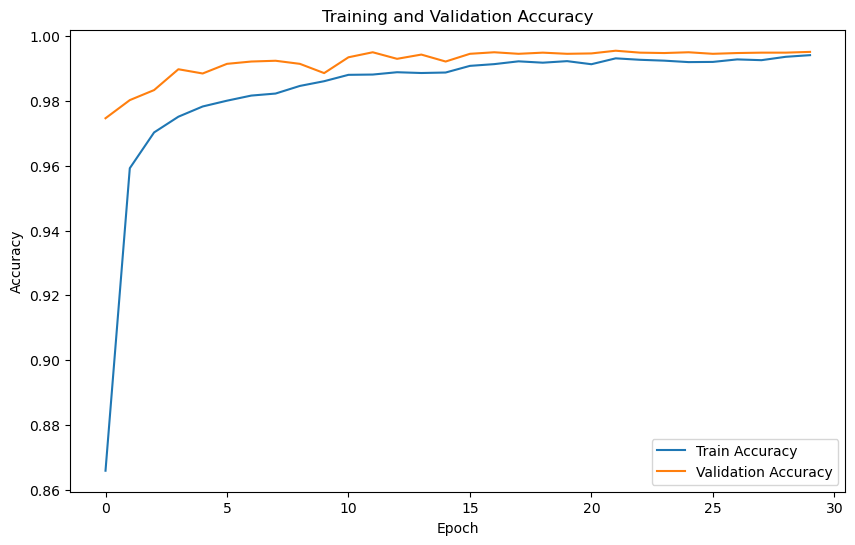

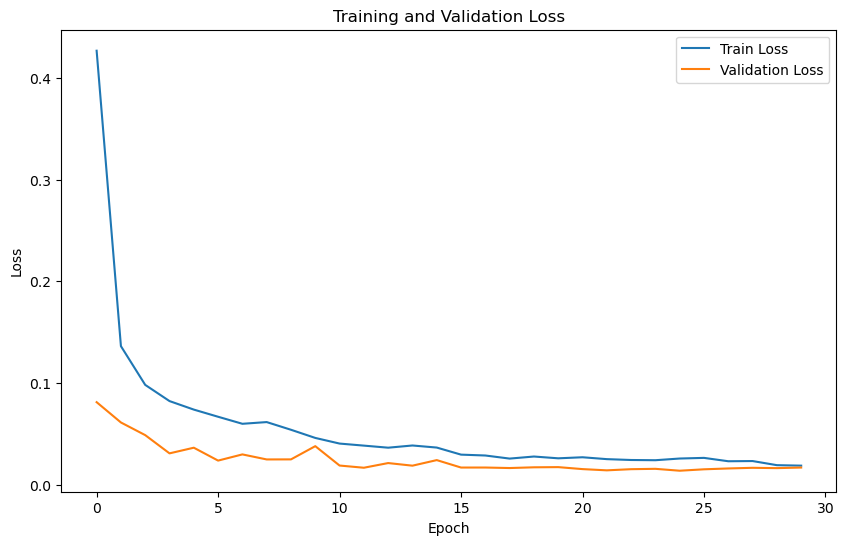

In [25]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

### Make Predictions and Create Submission

The trained model is used to make predictions on the test dataset. Predicted labels are converted to the final submission format.

In [26]:
# Evaluate the model on the test set
X_test = test.values.reshape(-1, 28, 28, 1)
predictions = model.predict(X_test)

# Convert predictions to labels (using the class with highest probability)
predicted_labels = np.argmax(predictions, axis=1)

# Create a submission DataFrame
submission = pd.DataFrame({'ImageId': np.arange(1, len(predicted_labels) + 1),
                           'Label': predicted_labels})

# Save the submission DataFrame to a CSV file
submission.to_csv('submission.csv', index=False)

875/875 [==============================] - 40s 45ms/step
